In [22]:
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import hvplot.pandas  # noqa
from datetime import timedelta


df = pd.read_csv("data/tsg_gps/EventData/DataLogger/Data every 1 min_001.elg")
df.head()

Date      Time  SW-ZDA-Year  SW-ZDA-Month  SW-ZDA-Day  SW-ZDA-Time  \
0  08/25/2021  12:46:24         2021             8          25    124935.70   
1  08/25/2021  12:47:25         2021             8          25    125035.70   
2  08/25/2021  12:48:25         2021             8          25    125135.70   
3  08/25/2021  12:49:25         2021             8          25    125235.69   
4  08/25/2021  12:50:25         2021             8          25    125336.69   

   SW-GGA-Lat SW-GGA-NorS  SW-GGA-Long SW-GGA-EorW  ...  \
0   3433.3240           N    7610.8499           W  ...   
1   3433.4081           N    7610.6764           W  ...   
2   3433.4919           N    7610.5111           W  ...   
3   3433.5739           N    7610.3362           W  ...   
4   3433.6615           N    7610.1648           W  ...   

   SW-Weather-HumidRel-%  SW-Wind-WindSpeedRel  SW-Wind-WindAngleRel  \
0                   76.1                  5.00                 76.40   
1                   75.7                  4.49                 86.89   
2                   75.2                  3.29                 95.20   
3                   75.6                  5.29                 80.90   
4                   75.3                  2.90                 99.29   

   TrueWind-DRV-SPEED  TrueWind-DRV-DIRECTION  TSG--temp-SBE38  TSG--sal  \
0               10.75                  219.05          27.7042   35.6590   
1               12.15                  215.33          27.6905   35.6585   
2               11.20                  214.90          27.6949   35.6639   
3               12.10                  213.94          27.6968   35.6928   
4               11.44                  221.88          27.6971   35.6891   

   SW-Depth-DBT-Depth below transducer (m)  DepthOverall-DRV-VALUE  \
0                                    36.91                   37.88   
1                                    37.36                   38.36   
2                                    37.80                   38.80   
3                                    36.98                   37.98   
4                                    36.95                   37.95   

   Unnamed: 24  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [2]:
len(df)

6859

In [24]:
from datetime import datetime

date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']+ timedelta(minutes=4)
df  = df.set_index('utc_dt')

In [4]:
import numpy as np

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

<AxesSubplot:>

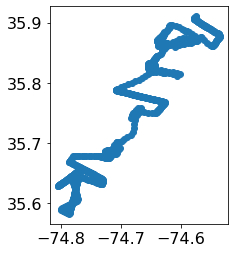

In [408]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.loc['2021-08-27 8:00:00':'2021-08-27 23:45:00'].plot()

In [410]:
df.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [405]:
df.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [154]:
df.loc['2021-08-27 8:00:00':'2021-08-27 23:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [149]:
df.loc['2021-08-27 16:00:00':'2021-08-27 17:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2,tiles='EsriNatGeo', width=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [7]:
cdom_data = open('data/cdom/cdom_flu_output_210827_1.txt')

In [8]:
lines = cdom_data.readlines()

In [9]:
sensor_values = []
utc_times = []
for i in range(len(lines)):
    line = lines[i]
    if "sensor" in line:
        try:
            line = line.split('= ')[1]
            line = line.replace('\n', '')
            sensor_values.append(int(line))
            if "UTC" in lines[i-1]:
                data_time = lines[i-1][5:-2]
                utc_times.append(data_time)
            elif "UTC" in lines[i+1]:
                data_time = lines[i+1][5:-2]
                utc_times.append(data_time)
        except:
            pass

In [10]:
len(sensor_values)-len(utc_times)

2

In [11]:
sensor_values = sensor_values[2:]

In [12]:
utc_times = pd.to_datetime(utc_times)

In [13]:
cdom_df = pd.DataFrame(np.array(sensor_values)/1024.0*5, columns = ['cdom_volts'])

In [14]:
cdom_df['utc_dt'] = utc_times

In [15]:
cdom_df  = cdom_df.set_index('utc_dt')

<AxesSubplot:xlabel='utc_dt'>

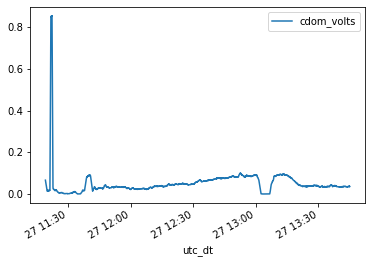

In [16]:
cdom_df.rolling(window=120*1).mean().loc['2021-08-27 11:00:00':'2021-08-27 13:45:00'].plot()

In [46]:
cdom_df['bin_cdom']= cdom_df.rolling(window=120*2).mean().cdom_volts

<AxesSubplot:xlabel='utc_dt'>

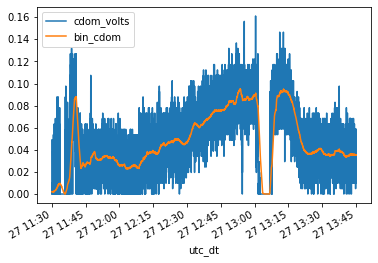

In [47]:
cdom_df.loc['2021-08-27 11:30:00':'2021-08-27 13:45:00'].plot()

(0.0, 0.4)

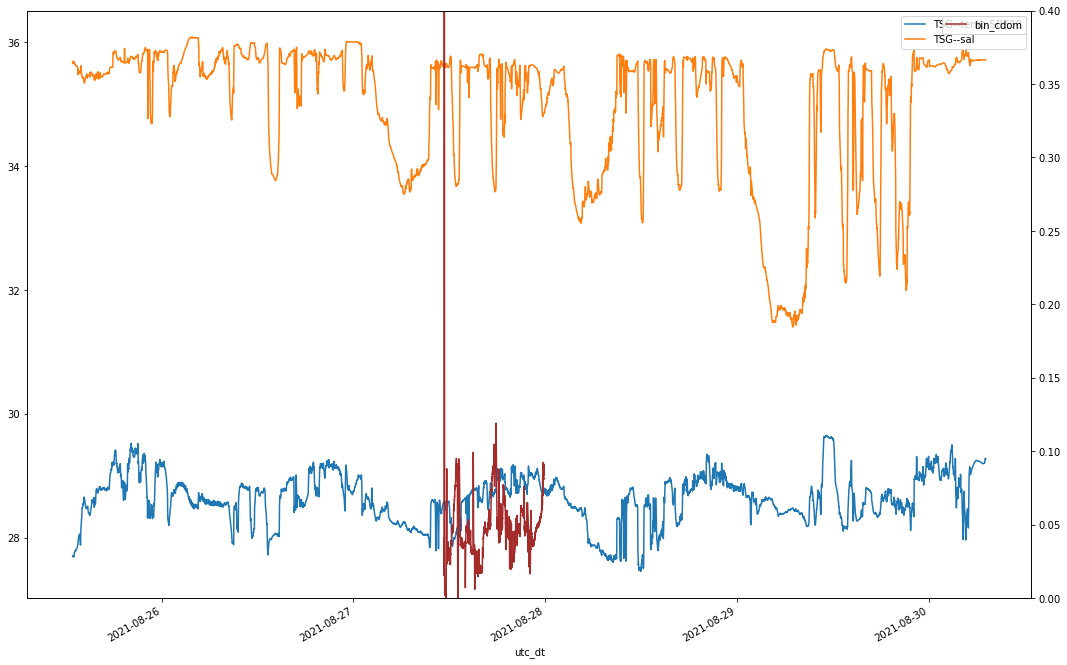

In [48]:
fig, ax = plt.subplots(figsize=(18,12))
df.plot(y='TSG--temp-SBE38',ax=ax)
df.plot(y='TSG--sal',ax=ax)
ax2 = ax.twinx()
cdom_df.plot(y='bin_cdom', ax=ax2, color='brown')
ax2.set_ylim(0, .4)

In [49]:
df_transect = df.loc['2021-08-27 13:00:00':'2021-08-27 14:30:00']
cdom_df_transect = cdom_df.loc['2021-08-27 13:00:00':'2021-08-27 14:30:00']

In [50]:
# df_transect = df.loc['2021-08-29 11:00:00':'2021-08-29 13:30:00']
# cdom_df_transect = cdom_df.loc['2021-08-29 11:00:00':'2021-08-29 13:30:00']

<AxesSubplot:xlabel='utc_dt'>

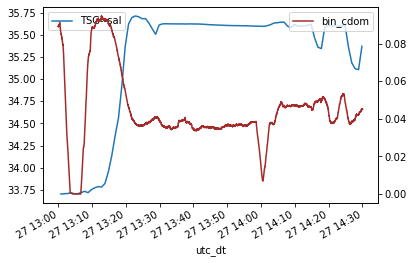

In [51]:
fig, ax = plt.subplots()
# df_transect.plot(y='TSG--temp-SBE38',ax=ax)
df_transect.plot(y='TSG--sal',ax=ax)
ax2 = ax.twinx()
cdom_df_transect.plot(y='bin_cdom', ax=ax2, color='brown')

### Radiometer Data

In [52]:
trios_df = pd.read_csv('data/trios/shearwater_trios_20210827.csv')

In [53]:
trios_df['datetime'] = pd.to_datetime(trios_df['TimeStamp'])
trios_df['utc_dt'] =trios_df['datetime'] + timedelta(hours=4)
trios_df = trios_df.set_index('utc_dt')

In [60]:
df_transect = df.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00']
cdom_df_transect = cdom_df.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00']
trios_df_transect = trios_df.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00']

<AxesSubplot:xlabel='utc_dt'>

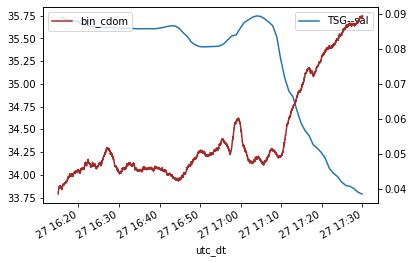

In [61]:
fig, ax = plt.subplots()
# df_transect.plot(y='TSG--temp-SBE38',ax=ax)
df_transect.plot(y='TSG--sal',ax=ax)
ax2 = ax.twinx()
cdom_df_transect.plot(y='bin_cdom', ax=ax2, color='brown')

In [290]:
chlci_transect = oc_index(trios_df_transect.iloc[:, 156:161].mean(axis=1).values, trios_df_transect.iloc[:, 232:240].mean(axis=1).values, trios_df_transect.iloc[:, 346:351].mean(axis=1).values)

In [292]:
trios_df_transect['chl'] = chlci_transect

<ipython-input-292-8c3f1fbbe830>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df_transect['chl'] = chlci_transect


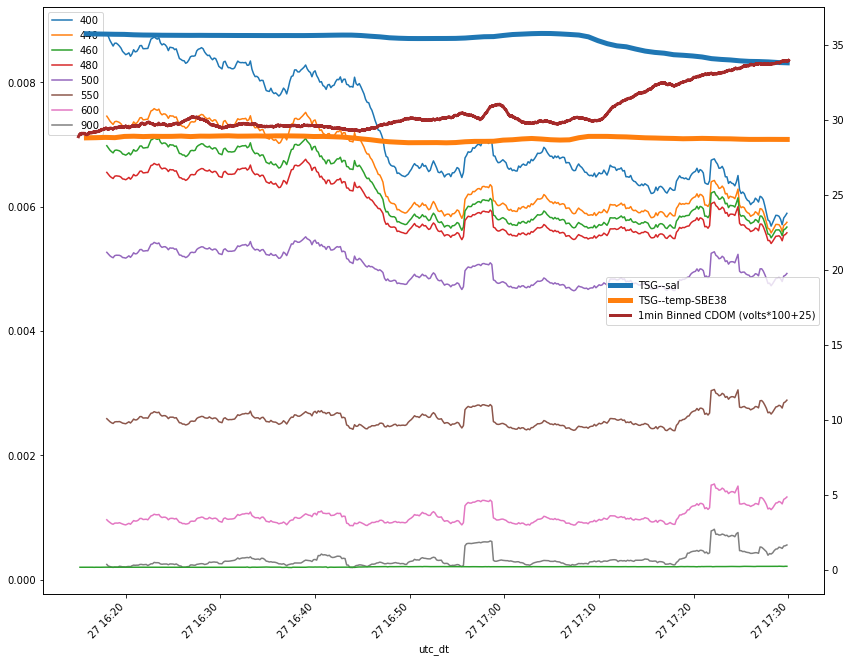

In [293]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()

df_transect.plot(y='TSG--sal',ax=ax2, linewidth=5)
df_transect.plot(y='TSG--temp-SBE38',ax=ax2, linewidth=5)
(cdom_df_transect.bin_cdom*100+25).plot(color='brown', ax=ax2, linewidth=3, label='1min Binned CDOM (volts*100+25)')
ax2.legend()

trios_df_transect['400'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['440'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['460'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['480'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['500'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['550'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['600'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['900'].rolling(window=6*3).mean().plot(ax=ax)

# trios_gdf.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00'].plot('chl', ax=ax)

ax.legend(loc='upper left')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('sal_temp_cdom_radiometry.png')

In [299]:
plt.rcParams.update({'font.size': 16})

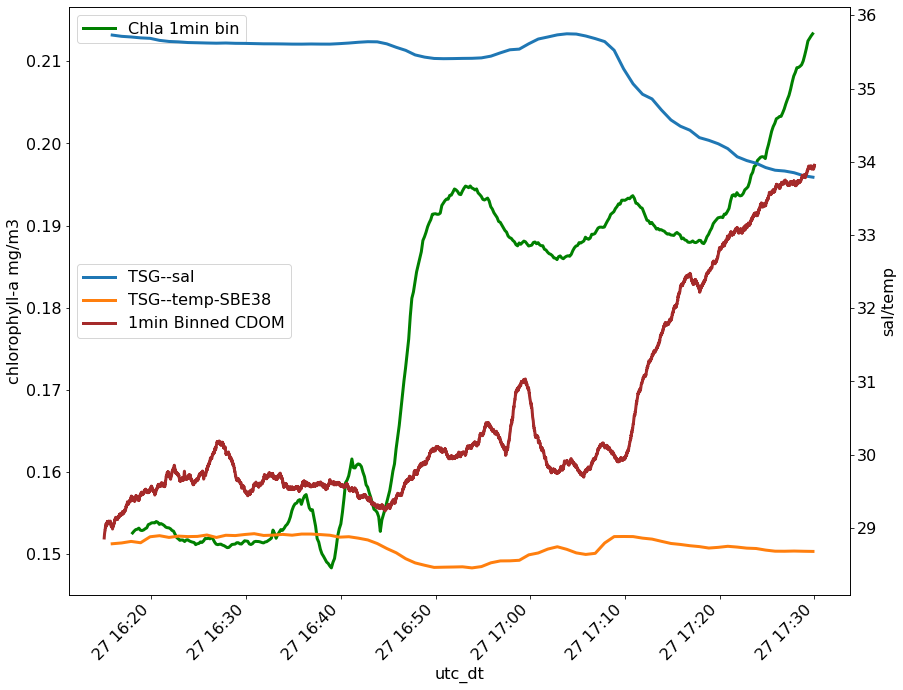

In [302]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()

df_transect.plot(y='TSG--sal',ax=ax2, linewidth=3)
df_transect.plot(y='TSG--temp-SBE38',ax=ax2, linewidth=3)
(cdom_df_transect.bin_cdom*100+25).plot(color='brown', ax=ax2, linewidth=3, label='1min Binned CDOM')
ax2.legend()


trios_df_transect['chl'].rolling(window=6*3).mean().plot(ax=ax, color='green', label='Chla 1min bin', linewidth=3)

# trios_gdf.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00'].plot('chl', ax=ax)

ax.legend(loc='upper left')
ax.set_ylabel('chlorophyll-a mg/m3')
ax2.set_ylabel('sal/temp')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
fig.savefig('sal_temp_cdom_chla.png')

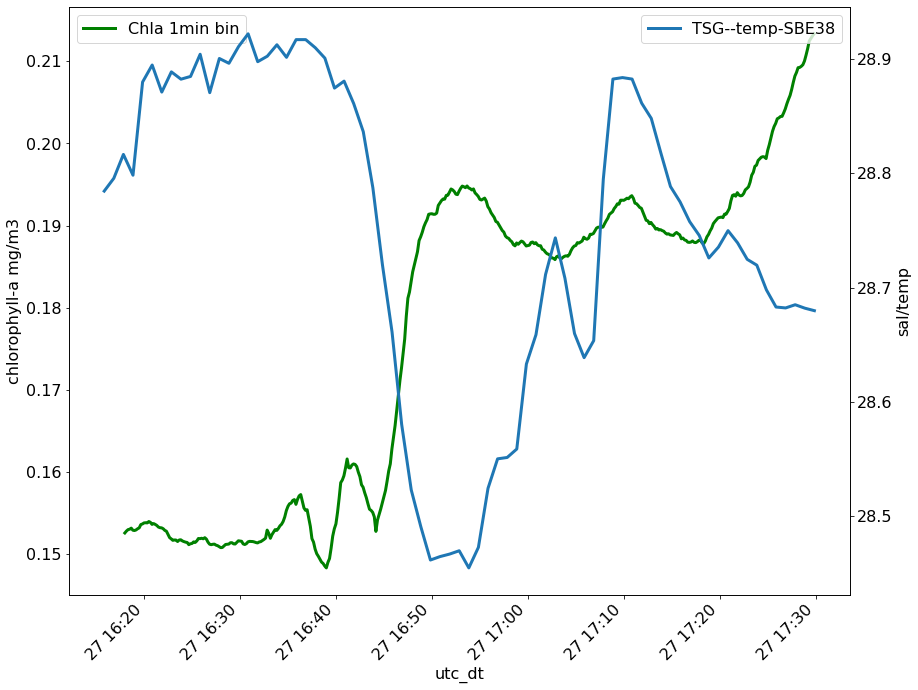

In [407]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()

# df_transect.plot(y='TSG--sal',ax=ax2, linewidth=3)
df_transect.plot(y='TSG--temp-SBE38',ax=ax2, linewidth=3)
# (cdom_df_transect.bin_cdom*100+25).plot(color='brown', ax=ax2, linewidth=3, label='1min Binned CDOM')
ax2.legend()


trios_df_transect['chl'].rolling(window=6*3).mean().plot(ax=ax, color='green', label='Chla 1min bin', linewidth=3)

# trios_gdf.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00'].plot('chl', ax=ax)

ax.legend(loc='upper left')
ax.set_ylabel('chlorophyll-a mg/m3')
ax2.set_ylabel('sal/temp')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('sal_temp_cdom_chla.png')

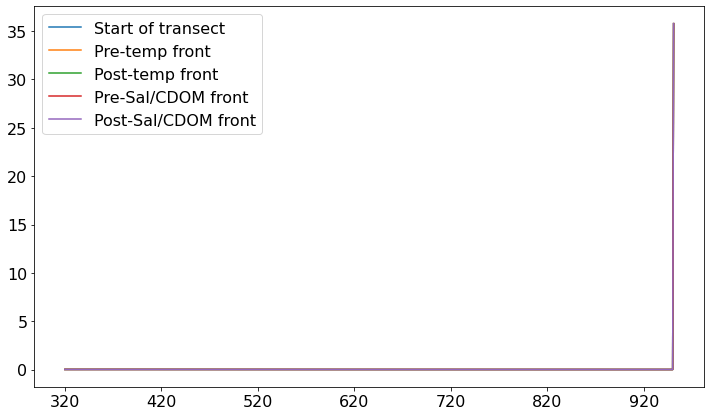

In [427]:
fig,ax = plt.subplots(figsize=(12,7))
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
trios_df_transect.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.legend()
# plt.savefig('radiometry_spectra.png')


<AxesSubplot:>

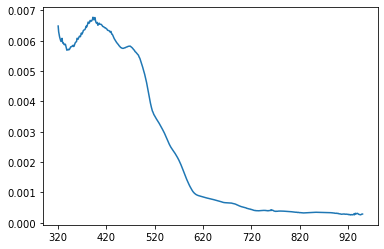

In [155]:
lats = []
lons = []
for i in range(len(trios_df)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(trios_df.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)

In [156]:
trios_df['lat'] = lats
trios_df['lon'] = lons

In [157]:
import geopandas as gpd

trios_gdf = gpd.GeoDataFrame(
    trios_df, geometry=gpd.points_from_xy(trios_df.lon, trios_df.lat))

<AxesSubplot:>

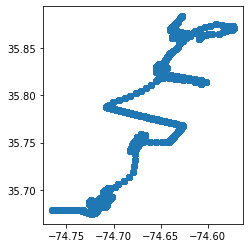

In [158]:
trios_gdf.plot()

In [166]:
trios_gdf.columns[1:-4]

Index(['320', '321', '322', '323', '324', '325', '326', '327', '328', '329',
       ...
       '941', '942', '943', '944', '945', '946', '947', '948', '949', '950'],
      dtype='object', length=631)

In [241]:
ci1 = -0.49
ci2 = 191.6590

# ci1 = -0.38152295986028695
# ci2 = 271.37634868

# average of 443*.5 + 489*1.5
# ci1 = -0.30002281538304754
# ci2 = 310.5772338

# ci1 = -0.21380600002416383
# ci2 = 572.01573044



def oc_index(blue, green, red):
    blue, green, red = blue, green, red
    CI = green - ( blue + (555 - 477)/(667 - 477) * (red - blue) )
    
    #print(green)
    #print(( blue + (555 - 443)/(667 - 443) * (red - blue) ))
    
    #print(CI)

    ChlCI = 10**(ci1 + ci2*CI)
    return(ChlCI)

In [243]:
chlci = oc_index(trios_gdf.iloc[:, 156:161].mean(axis=1).values, trios_gdf.iloc[:, 232:240].mean(axis=1).values, trios_gdf.iloc[:, 346:351].mean(axis=1).values)

In [251]:
chlci[chlci>.5] = .5

(0.1, 0.32)

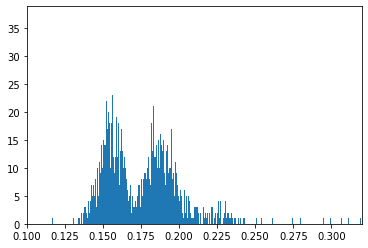

In [253]:
plt.hist(chlci, bins=2000)
plt.xlim(0.1,.32)

In [222]:
trios_gdf.iloc[:, 156:161].mean(axis=1).values

array([0.00719962, 0.00702049, 0.00608499, ..., 0.01105115, 0.00601578,
       0.00627533])

In [232]:
trios_gdf.iloc[:, 232:240].mean(axis=1).values

utc_dt
2021-08-27 13:11:50    0.004480
2021-08-27 13:12:00    0.004295
2021-08-27 13:12:10    0.003679
2021-08-27 13:12:20    0.006315
2021-08-27 13:12:30    0.004902
                         ...   
2021-08-27 21:23:00    0.003440
2021-08-27 21:23:10    0.004263
2021-08-27 21:23:20    0.008379
2021-08-27 21:23:30    0.003110
2021-08-27 21:23:40    0.003312
Length: 2919, dtype: float64

In [239]:
trios_gdf.iloc[:, 346:351].mean(axis=1).values

array([0.00259821, 0.00234837, 0.00205165, ..., 0.00616506, 0.00132067,
       0.0014643 ])

In [178]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(trios_gdf.values[:,1:-4])

In [179]:
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([1581,    1,    4,   18,    2,   31,    1,    7,   15,    1,    3,
          48, 1190,   16,    1]))

In [258]:
trios_gdf['chl'] = chlci

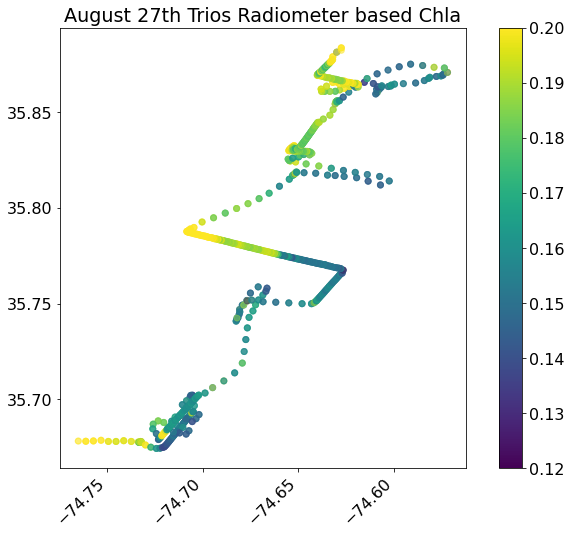

In [308]:
fig, ax = plt.subplots(figsize=(12,9))
sc = trios_gdf.plot('chl', ax=ax, vmin=.12,vmax=.20, cmap='viridis', alpha=0.3, label='CI Chla', legend=True)
# ss = ax.scatter(trios_gdf.lon, trios_gdf.lat, c=trios_gdf.chl, s=100)
# fig.colorbar(sc,ax=ax)
# fig.colorbar(sc, ax=ax)
fig.autofmt_xdate(rotation=45)
ax.set_title('August 27th Trios Radiometer based Chla')
fig.savefig('trios_radiometers_chlaci.png')

<AxesSubplot:>

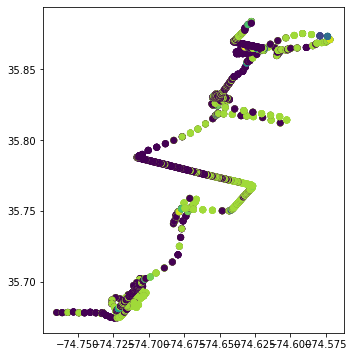

In [283]:
fig, ax = plt.subplots(figsize=(8,6))
trios_gdf.plot(c=kmeans.labels_,ax=ax)

In [310]:
trios_gdf_transect = trios_gdf.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00']

In [379]:
x = trios_gdf_transect.rolling(window=6).mean().values[:,1:-5]

In [380]:
x = x[12:,:]

In [381]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [382]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [383]:
principalComponents.shape

(433, 2)

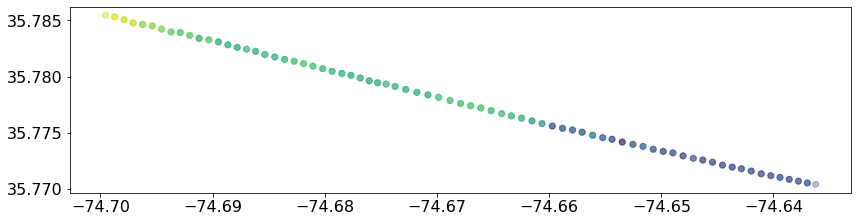

In [413]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=trios_gdf_transect.iloc[12:].chl,ax=ax, alpha=0.2, vmin=0.2, vmax=.24)
fig.savefig('chla_transect.png')

In [ ]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=trios_gdf_transect.iloc[12:].chl,ax=ax, alpha=0.2, vmin=0.2, vmax=.24)

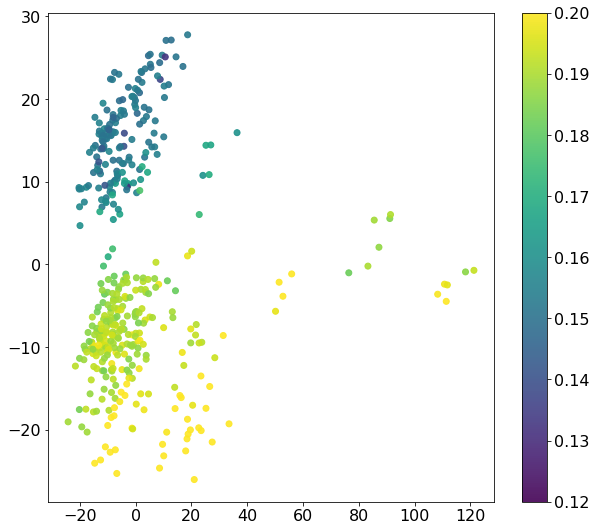

In [420]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chl'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
fig.savefig('pca_transect.png')

In [423]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(x)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([ 55, 210,  12,  44, 112]))

<AxesSubplot:>

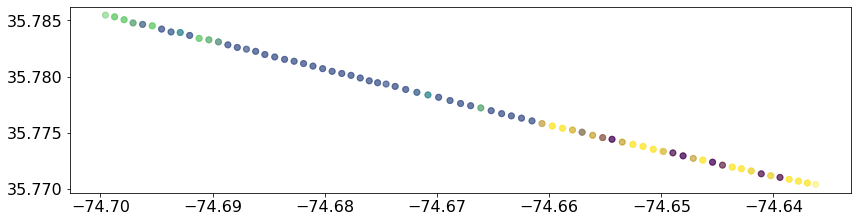

In [424]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=kmeans.labels_,ax=ax, alpha=0.2)

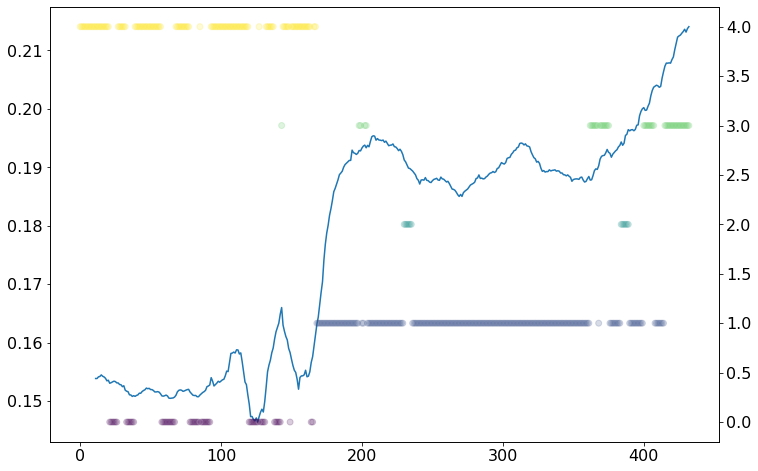

In [426]:
fig, ax  =plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,len(x)),trios_gdf_transect.chl.iloc[12:].rolling(window=12).mean())
ax2=ax.twinx()
ax2.scatter(np.arange(0,len(x)), kmeans.labels_, alpha=0.2, c=kmeans.labels_)
fig.savefig('cluster_chla.png')

In [88]:
lats = []
lons = []
for i in range(len(trios_df_transect)):
    row = df_transect.iloc[df_transect.index.get_loc(pd.to_datetime(trios_df_transect.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)

In [91]:
trios_df_transect['lat'] = lats
trios_df_transect['lon'] = lons

<ipython-input-91-aaa7d1eefef1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df_transect['lat'] = lats
<ipython-input-91-aaa7d1eefef1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df_transect['lon'] = lons


In [93]:
import geopandas as gpd

trios_gdf_transect = gpd.GeoDataFrame(
    trios_df_transect, geometry=gpd.points_from_xy(trios_df_transect.lon, trios_df_transect.lat))

<AxesSubplot:>

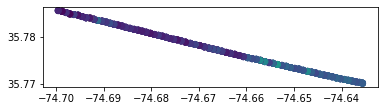

In [100]:
trios_gdf.plot('455')